<center><h1>False Discoveries occur Early on the Lasso Path</a></h1></center>
<center><h2>Paper Numerical Implementation</a></h2></center>

<center><h4>By: Ahmed Amine MAJDOUBI and Mehdi ABOU EL QASSIME</h4></center>

The following notebook is a numerical implementation of the main results of the paper <a href = 'https://arxiv.org/abs/1511.01957'>False Discoveries occur Early on the Lasso Path</a>, written by Weijie Su, Malgorzata Bogdan and Emmanuel Candes, as part of the course ’<a href='https://www.imo.universite-paris-saclay.fr/~giraud/MSV/statsDS.html'>Theoretical guidelines for high for highdimensional data analysis</a>’. This notebook is accompanied by a report that analyses the main results of the paper followed by some comments that discuss limitations of the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from scipy.optimize import fminbound
from sklearn.linear_model import lasso_path

%matplotlib inline

## True positive and false positive rates along the Lasso path

First of all, we will create a function that will enable us to draw the outcoumes of the TPP/FPP rates for a fixed 
number of independent experiments under the same Gaussian random design setting.

In [2]:
def get_tpps(n,p,ε,n_iter):
    """
    Get the TPP value when the first false variable enters the Lasso model
    """
    k = int(ε * p) 
    β = np.append(np.ones(k), np.zeros(p - k))
    tpp_ls = np.zeros(n_iter)
    
    for i in range(n_iter):
        X = np.random.normal(0, 1, (n, p))
        y = np.dot(X, β) + np.random.normal(0, 1, n)
        path = 1.*(lasso_path(X, y, n_alphas=100, fit_intercept=False)[1] != 0)
        
        for j in range(n_iter-1):
            path_j = path[:, j]
            tpp_ls[i] = sum((path_j == β) * (β == 1.)) / k
            
            if ((sum((path_j != β) * (path_j == 1.)) / sum(path_j)) if sum(path_j) != 0 else 0) != 0.:
                break
    
    return tpp_ls

def get_fdps(n,p,ε,n_iter):
    """
    Get the False Discovery Proportion the first time TPP reaches one
    """
    k = int(ε * p) 
    β = np.append(np.ones(k), np.zeros(p - k))
    fdp_ls = np.zeros(n_iter)
    
    for i in range(n_iter):
        X = np.random.normal(0, 1, (n, p))
        y = np.dot(X, β) + np.random.normal(0, 1, n)
        path = 1.*(lasso_path(X, y, n_alphas=100, fit_intercept=False)[1] != 0)
        
        for j in range(n_iter-1):
            path_j = path[:, j]
            fdp_ls[i] = ((sum((path_j != β) * (path_j == 1.)) / sum(path_j)) if sum(path_j) != 0 else 0)
            
            if (sum((path_j == β) * (β == 1.)) / k) == 1.:
                break
    
    return fdp_ls

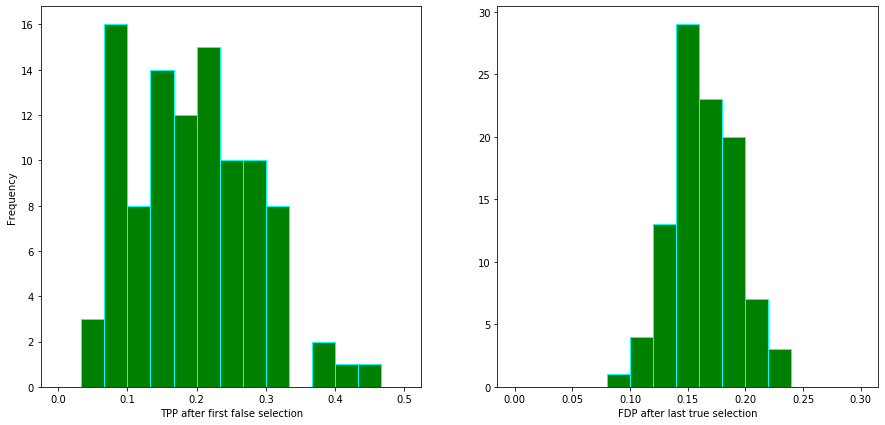

In [3]:
n = 1000
p = 1000
ε = 0.2
n_iter = 100

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.hist(get_tpps(n,p,ε,n_iter), bins=15, range=[0, 0.5], color='green', edgecolor='aqua')
plt.xlabel('TPP after first false selection')
plt.ylabel('Frequency')


plt.subplot(1,2,2)
plt.hist(get_fdps(n,p,ε,n_iter), bins=15, range=[0, 0.3], color='green', edgecolor='aqua')
plt.xlabel('FDP after last true selection')

plt.show()

## Boundary curve function q*

The function is based on the <a href = 'https://github.com/wjsu/fdrlasso/blob/master/fdrlasso.m'>matlab code</a> provided by paper authors. First, let's define two functions that will help us calculate q*.

In [4]:
def lr_delta_sandwich(t, tpp, δ, ε):
    """
    Return the difference between left and right sandwich
    """
    a,b,c = 1+pow(t,2), norm.cdf(-t), norm.pdf(t)
    return ((1-ε)*(2*a*b - 2*t*c) + ε*a - δ) / (ε*(a*(1-2*b) + 2*t*c)) - (1 - tpp)/(1 - 2*b)

def max_power(δ, ε):
    """
    Return highest power for δ < 1 and ε > ε_phase,
    Else return 1
    """
    minus_f = lambda x: -(1+2/δ*x*norm.pdf(x) - 2/δ*(1+x**2)*norm.cdf(-x))/(1+x**2-2*(1+x**2)*norm.cdf(-x)+2*x*norm.pdf(x))*δ
    ε_phase = -minus_f(fminbound(minus_f, 0, 8))
    
    if (ε <= ε_phase) | (δ >= 1):
        return 1
    else:
        return (ε - ε_phase)*(δ - ε_phase)/ε/(1 - ε_phase) + ε_phase/ε

Now let's define the boundray curve function

In [5]:
def boundary_curve(tpp_ls, sbs_rate, sp_ratio):
    """
    Compute the boundary curve of the Lasso trade-off.
    
    Returns: the boudary curve q*
    
    Parameters:
    
    - tpp_ls: list of true positive proportions
    - sbs_rate: the subsampling rate
    - sp_ratio: the sparsity ratio
    
    Condition:
    
    - (sbs_rate, sp_ratio) ∈ [0,1]
    - if (sbs_rate, sp_ratio) above the Donoho-Tanner phase transition, 
    then TPP (true positive proportion) must be <= u* (highest power of sbs_rate and sp_ratio)
    """
    
    boundary_curve_ls = []
    
    for tpp in tpp_ls:
        
        if tpp > max_power(sbs_rate, sp_ratio):
            boundary_curve_ls.append(None)
        elif tpp == 0:
            boundary_curve_ls.append(0)
        else:
            step_size = 0.1
            tmax = max(10, np.sqrt(sbs_rate/sp_ratio/tpp) + 1)
            tmin = tmax - step_size

            while tmin > 0:
                if lr_delta_sandwich(tmin, tpp, sbs_rate, sp_ratio) < 0:
                    break

                tmax = tmin
                tmin = tmax - step_size

            if tmin <= 0:
                step_size = step_size/100
                tmax = max(10, np.sqrt(sbs_rate/sp_ratio/tpp) + 1)
                tmin = tmax - step_size
                while tmin > 0:
                    if lr_delta_sandwich(tmin, tpp, sbs_rate, sp_ratio) < 0:
                        break

                    tmax = tmin
                    tmin = tmax - step_size

            diff = tmax - tmin
            while diff > 1e-6:
                tmid = 0.5*tmax + 0.5*tmin
                if lr_delta_sandwich(tmid, tpp, sbs_rate, sp_ratio) > 0:
                    tmax = tmid
                else: 
                    tmin = tmid

                diff = tmax - tmin

            t = (tmax + tmin)/2
            boundary_curve_ls.append(2*(1 - sp_ratio)*norm.cdf(-t)/(2*(1 - sp_ratio)*norm.cdf(-t) + sp_ratio*tpp))

    return np.array(boundary_curve_ls)

Nowhere on the Lasso path can both types of error rates be simultaneously low, and this impossible section lies under the curve q*. Now let's display the Lasso trade-off diagram as well as the boudary curve diagram as shown in the paper.

## Lasso Trade-off Diagram

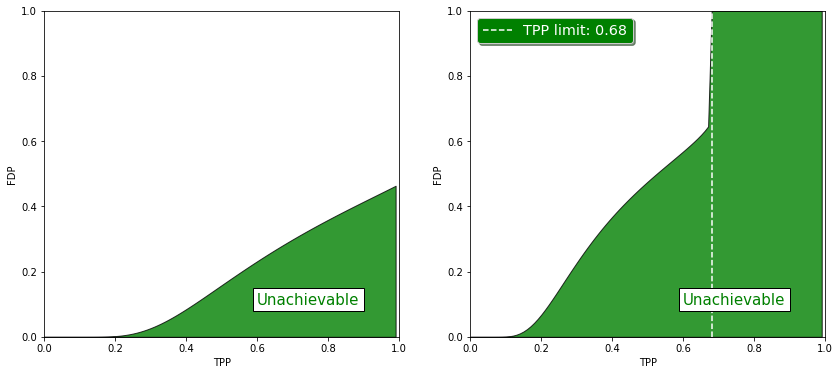

In [6]:
tpp_ls = np.arange(100) / 100
δ_ls = [0.5, 0.3]
ε_ls = [0.15, 0.15]

plt.figure(figsize=(14,6))

for i in range(len(ε_ls)):
    plt.subplot(1, 2, i+1)
    boundary_curve_lst = boundary_curve(tpp_ls, δ_ls[i], ε_ls[i])
    if (None in boundary_curve_lst):
        index = tpp_ls[np.where(boundary_curve_lst == None)[0][0]]
        plt.axvline(index, linestyle="--", color="white", label="TPP limit: %.2f" % index)
        legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
        legend.get_frame().set_facecolor('green')
        legend.get_texts()[0].set_color("white")
    boundary_curve_lst[boundary_curve_lst == None] = 1.
    plt.text(0.6, 0.1, 'Unachievable', bbox=dict(facecolor='white'), color='green', fontsize=15)
    plt.fill_between(tpp_ls, np.array(boundary_curve_lst, dtype=float), facecolor='green', edgecolor="black", alpha=0.8)
    plt.xlabel("TPP")
    plt.xlim(0., 1.)
    plt.ylabel("FDP")
    plt.ylim(0., 1.)
plt.show()

## Boundary Curve Diagram

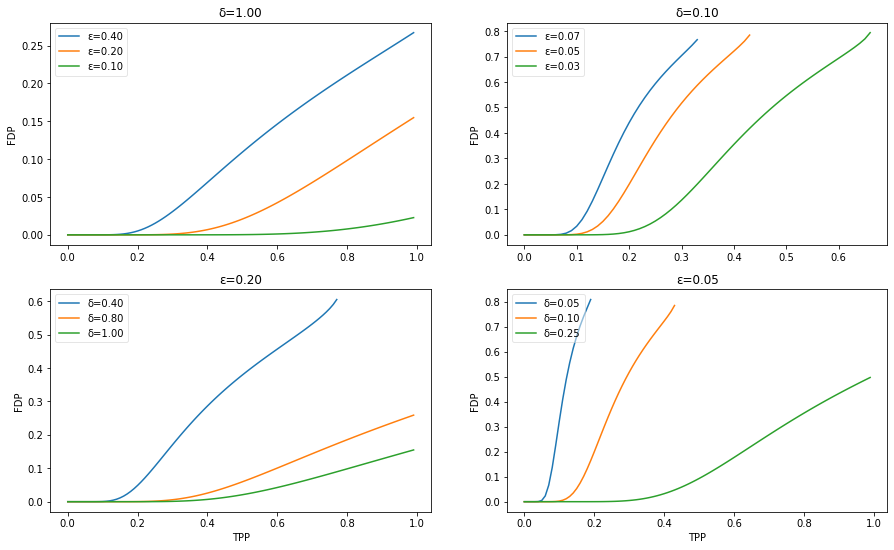

In [7]:
tpp_ls = np.arange(100) / 100
δ_ls = [(0.4, 0.8, 1), (0.05, 0.1, 0.25)]
ε_ls = [(0.4, 0.2, 0.1), (0.07, 0.05, 0.03)]

plt.figure(figsize=(15, 9))

for i, δ in enumerate([1., .1]):
    plt.subplot(2, 2, i+1)
    for j, ε in enumerate(ε_ls[i]):
        plt.plot(tpp_ls, boundary_curve(tpp_ls, δ, ε), label=r"ε=%.2f" % ε)
    plt.title(r"δ=%.2f" % δ)
    plt.ylabel("FDP")
    plt.legend(loc='upper left', fancybox=True, framealpha=0.5)

for i, ε in enumerate([.2, .05]):
    plt.subplot(2, 2, i+3)
    for j, δ in enumerate(δ_ls[i]):
        plt.plot(tpp_ls, boundary_curve(tpp_ls, δ, ε), label=r"δ=%.2f" % δ)
    plt.title(r"ε=%.2f" % ε)
    plt.xlabel("TPP")
    plt.ylabel("FDP")
    plt.legend(loc='upper left', fancybox=True, framealpha=0.5)
    
plt.show()

## Numerical Simulations in the Noiseless Setup (σ=0)

In this section, we will provide the outcomes of numerical simulations for finite values of n and p in the noiseless
setup where $\sigma=0$. First, let's create a function that calculates the (TPP, FDP) pairs for a given simulation parameters. 

In [8]:
def fdp_tpp_curve(n, p, ε, n_α, n_paths):
    """
    Returns the TPP/FDP values for a given Numerical Simulation.
    
    Parameters:
    - n: number of observations
    - p: number of features
    - n_α: number of alphas along the regularization path
    - n_paths: number of lasso paths
    """
    
    fdp_ls = np.zeros(n_α*n_paths)
    tpp_ls = np.zeros(n_α*n_paths)
    k = int(ε * p) 
    β = np.append(np.ones(k), np.zeros(p - k))
    
    for i in range(n_paths):
        X = np.random.normal(0, 1, (n, p))
        y = np.dot(X, β) + np.random.normal(0, 1, n)

        path = 1.*(lasso_path(X, y, n_alphas=n_α, fit_intercept=False)[1] != 0)

        for l in range(n_α):
            path_l = path[:, l]            
            fdp_ls[l+i*n_α] = ((sum((path_l != β) * (path_l == 1.)) /  sum(path_l)) if  sum(path_l) != 0 else 0)
            tpp_ls[l+i*n_α] = sum((path_l == β) * (β == 1.)) / k
    
    return tpp_ls, fdp_ls

Next, let's plot the TPP/FDP pairs. We will look at the case where δ=n/p = 1. We will plot for n=1000 and n=5000, each along 10 independent Lasso paths, with ε=0,2 and P(Π=0) = 1−ε .

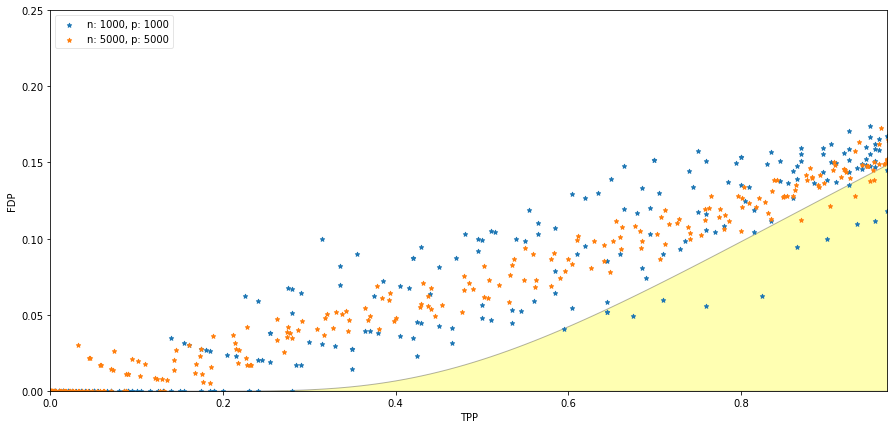

In [9]:
tpp_ls = np.arange(100) / 100
n_ls = [1000, 5000]
p_ls = [1000, 5000]
δ = 1.0
ε = 0.2
n_α = 100
n_paths = 10


plt.figure(figsize=(15, 7))

boundary_curve_lst = boundary_curve(tpp_ls, δ, ε)
plt.fill_between(tpp_ls, np.array(boundary_curve_lst, dtype=float), facecolor='yellow', edgecolor="black", alpha=0.3)

for i in range(len(n_ls)): 
    tpp_ls, fdp_ls = fdp_tpp_curve(n_ls[i], p_ls[i], ε, n_α, n_paths)
    plt.scatter(tpp_ls, fdp_ls, marker= "*", s=20, label="n: %d, p: %d" % (n_ls[i], p_ls[i]))
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.xlim(0., 0.97)
plt.ylim(0., .25)
plt.legend(loc='upper left', fancybox=True, framealpha=0.5)
plt.show()